In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
import prodimopy.plot as pplot
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.signal import correlate, fftconvolve
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    if wl.size == 0:
        return 0
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise

In [3]:
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionNN, self).__init__()
        # First hidden layer
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()

        # Second hidden layer
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()

        # Output layer
        self.output = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # First hidden layer and ReLU activation
        x = self.relu1(self.layer1(x))

        # Second hidden layer and ReLU activation
        x = self.relu2(self.layer2(x))

        # Output layer
        return self.output(x)

In [4]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
min_wl = 4.9
max_wl = 29
window_size = 1
windows_array = np.arange(min_wl, max_wl, window_size)
total_number_of_datasets = 100
X = []
y = []
for i, row in tqdm(df.iterrows()):
    for _ in range(total_number_of_datasets//25):
        wl = row['FLiTs Wavelength']
        flux = row['FLiTs Flux'] + row['FLiTs Flux Continuum']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = np.interp(wl, NH3_wl, row['FLiTs NH3 Flux'])
        flux = add_noise(flux, SNR=3)-row['FLiTs Flux Continuum'] + NH3_flux
        dat = []
        for index_window in range(len(windows_array)):
            window_start = windows_array[index_window]
            window_end = window_start + window_size
            flux_value = total_flux(wl[(wl > window_start) & (wl < window_end)], flux[(wl > window_start) & (wl < window_end)])
            dat.append(flux_value)
        X.append(dat)
        y.append(total_flux(wl, NH3_flux + np.random.normal(0, 10*np.mean(NH3_flux), size=len(wl))))



25it [00:06,  3.93it/s]


In [6]:
class RegressionNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionNN, self).__init__()
        # First hidden layer
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()

        # Second hidden layer
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()

        # Output layer
        self.output = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # First hidden layer and ReLU activation
        x = self.relu1(self.layer1(x))

        # Second hidden layer and ReLU activation
        x = self.relu2(self.layer2(x))

        # Output layer
        return self.output(x)

# Split first
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.1, random_state=42)

# Normalize based on training data only
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Hyperparameters
input_size = X_train_scaled.shape[1]  # 2 features
hidden_size = 8                 # You can change this to experiment

# Instantiate model, loss, and optimizer
model = RegressionNN(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.8f}")

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    actual = y_test_tensor.numpy()

# Inverse transform to get original scale
predictions_original = scaler_y.inverse_transform(predictions)
actual_original = scaler_y.inverse_transform(actual)

# Plot predictions vs actuals on original scale
plt.scatter(actual_original, predictions_original)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'k--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

NameError: name 'X_scaled' is not defined

In [139]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

In [140]:
min_wl = 4.9
max_wl = 29
window_size = 1
windows_array = np.arange(min_wl, max_wl, window_size)
total_number_of_datasets = 1000
X_new = []
y_new = []
for i, row in tqdm(df.iterrows()):
    wl = row['FLiTs Wavelength']
    flux = row['FLiTs Flux'] + row['FLiTs Flux Continuum']
    NH3_wl = row['FLiTs NH3 Wavelength']
    NH3_flux = np.interp(wl, NH3_wl, row['FLiTs NH3 Flux'])
    flux = add_noise(flux, SNR=30)-row['FLiTs Flux Continuum'] + NH3_flux
    dat = []
    for index_window in range(len(windows_array)):
        window_start = windows_array[index_window]
        window_end = window_start + window_size
        flux_value = total_flux(wl[(wl > window_start) & (wl < window_end)], flux[(wl > window_start) & (wl < window_end)])
        dat.append(flux_value)
    X_new.append(dat)

    y_new.append(total_flux(wl, NH3_flux))
X_new = np.array(X_new)
y_new = np.array(y_new)

25it [00:01, 22.83it/s]


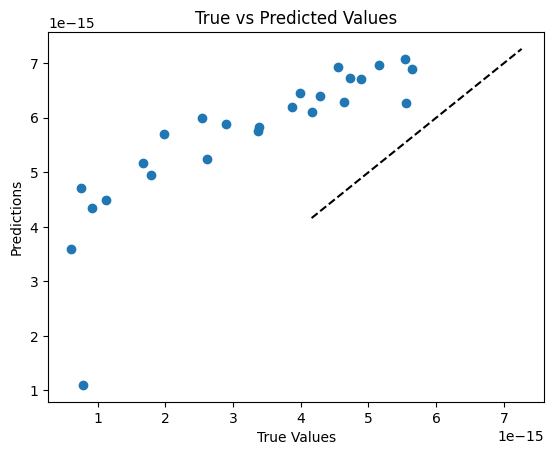

In [141]:
X_new_scaled = scaler_X.transform(X_new)

y_new_scaled = scaler_y.transform(y_new.reshape(-1, 1))

# Convert to tensors
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)
y_new_tensor = torch.tensor(y_new_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions = model(X_new_tensor).numpy()
    actual = y_new_tensor.numpy()

# Inverse transform to get original scale
predictions_original = scaler_y.inverse_transform(predictions)
actual_original = scaler_y.inverse_transform(actual)

plt.scatter(actual_original, predictions_original)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'k--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

In [7]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [53]:
species = ['NO']
X = []
y = []
total_wl = np.linspace(4.9, 6.5, 1000)
for i, row in tqdm(df.iterrows()):
    if i in [10, 15, 16, 20, 21, 22]:
        continue
    for _ in range(100):
        wl = row['FLiTs Wavelength']
        NH3_wl = row['FLiTs NH3 Wavelength']
        NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NH3 Flux'])
        flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
        flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
        flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
        dat = []
        for specie in species:
            specie_wl = row[f'FLiTs {specie} Wavelength']
            specie_flux = row[f'FLiTs {specie} Flux']
            specie_flux = np.interp(total_wl, specie_wl, specie_flux)
            dat.append(specie_flux+np.random.normal(0,0*abs(np.mean(specie_flux)), len(specie_flux)))
        X.append(flux)
        y.append(dat)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
print(X.shape, y.shape)

25it [00:03,  6.70it/s]

(1900, 1000) (1900, 1, 1000)


In [54]:
from torch.utils.data import DataLoader, TensorDataset

class SpectralCNN(nn.Module):
    def __init__(self, input_length=10000, num_species=11):
        super(SpectralCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=9, padding=4),  # (B, 16, 10000)
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, padding=4),  # (B, 32, 10000)
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=9, padding=4),  # (B, 64, 10000)
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=9, padding=4),  # (B, 32, 10000)
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=9, padding=4),  # (B, 16, 10000)
            nn.ReLU(),
            nn.Conv1d(16, num_species, kernel_size=9, padding=4)  # (B, 11, 10000)
        )

    def forward(self, x):
        # Input x shape: (B, 10000)
        x = x.unsqueeze(1)  # → (B, 1, 10000)
        features = self.encoder(x)
        out = self.decoder(features)  # → (B, 11, 10000)
        return out

X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (100, 10000)
y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (100, 11, 10000)

# Create a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Create DataLoader for batching and shuffling
batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = SpectralCNN(input_length=10000, num_species=len(species))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

num_epochs = 100
print_interval = 10
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0  # To track total loss for the current epoch
    for batch_idx, (xb, yb) in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        pred = model(xb)

        # Compute loss
        loss = loss_fn(pred, yb)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss for the epoch
        epoch_loss += loss.item()

        # Print the loss at specified intervals
        if (batch_idx + 1) % print_interval == 0:
            # print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")
            pass

    # Print average loss for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.6e}")

  1%|          | 1/100 [00:03<05:22,  3.26s/it]

Epoch [1/100] completed. Average Loss: 3.226183e-05


  2%|▏         | 2/100 [00:06<05:27,  3.34s/it]

Epoch [2/100] completed. Average Loss: 5.881421e-06


  3%|▎         | 3/100 [00:10<05:24,  3.35s/it]

Epoch [3/100] completed. Average Loss: 4.974047e-06


  4%|▍         | 4/100 [00:13<05:17,  3.30s/it]

Epoch [4/100] completed. Average Loss: 4.068335e-06


  5%|▌         | 5/100 [00:16<05:13,  3.30s/it]

Epoch [5/100] completed. Average Loss: 3.773385e-06


  6%|▌         | 6/100 [00:19<05:08,  3.28s/it]

Epoch [6/100] completed. Average Loss: 3.586967e-06


  7%|▋         | 7/100 [00:22<05:02,  3.25s/it]

Epoch [7/100] completed. Average Loss: 3.439717e-06


  8%|▊         | 8/100 [00:26<04:53,  3.19s/it]

Epoch [8/100] completed. Average Loss: 3.278939e-06


  9%|▉         | 9/100 [00:29<04:49,  3.18s/it]

Epoch [9/100] completed. Average Loss: 3.199607e-06


 10%|█         | 10/100 [00:32<04:48,  3.20s/it]

Epoch [10/100] completed. Average Loss: 3.031698e-06


 11%|█         | 11/100 [00:35<04:47,  3.23s/it]

Epoch [11/100] completed. Average Loss: 2.951734e-06


 12%|█▏        | 12/100 [00:38<04:43,  3.22s/it]

Epoch [12/100] completed. Average Loss: 2.803121e-06


 13%|█▎        | 13/100 [00:42<04:40,  3.23s/it]

Epoch [13/100] completed. Average Loss: 2.679774e-06


 14%|█▍        | 14/100 [00:45<04:37,  3.23s/it]

Epoch [14/100] completed. Average Loss: 2.599131e-06


 15%|█▌        | 15/100 [00:48<04:33,  3.22s/it]

Epoch [15/100] completed. Average Loss: 2.427154e-06


 16%|█▌        | 16/100 [00:51<04:27,  3.18s/it]

Epoch [16/100] completed. Average Loss: 2.361471e-06


 17%|█▋        | 17/100 [00:54<04:22,  3.17s/it]

Epoch [17/100] completed. Average Loss: 2.242990e-06


 18%|█▊        | 18/100 [00:58<04:21,  3.19s/it]

Epoch [18/100] completed. Average Loss: 2.218477e-06


 19%|█▉        | 19/100 [01:01<04:19,  3.20s/it]

Epoch [19/100] completed. Average Loss: 2.024056e-06


 20%|██        | 20/100 [01:04<04:16,  3.21s/it]

Epoch [20/100] completed. Average Loss: 1.955025e-06


 21%|██        | 21/100 [01:07<04:11,  3.18s/it]

Epoch [21/100] completed. Average Loss: 1.870839e-06


 22%|██▏       | 22/100 [01:10<04:07,  3.17s/it]

Epoch [22/100] completed. Average Loss: 1.708832e-06


 23%|██▎       | 23/100 [01:13<04:02,  3.15s/it]

Epoch [23/100] completed. Average Loss: 1.734774e-06


 24%|██▍       | 24/100 [01:17<03:59,  3.15s/it]

Epoch [24/100] completed. Average Loss: 1.551869e-06


 25%|██▌       | 25/100 [01:20<03:57,  3.17s/it]

Epoch [25/100] completed. Average Loss: 1.598731e-06


 26%|██▌       | 26/100 [01:23<03:54,  3.17s/it]

Epoch [26/100] completed. Average Loss: 1.459604e-06


 27%|██▋       | 27/100 [01:26<03:54,  3.21s/it]

Epoch [27/100] completed. Average Loss: 1.472228e-06


 28%|██▊       | 28/100 [01:30<04:00,  3.34s/it]

Epoch [28/100] completed. Average Loss: 1.508478e-06


 29%|██▉       | 29/100 [01:33<03:58,  3.36s/it]

Epoch [29/100] completed. Average Loss: 1.239789e-06


 30%|███       | 30/100 [01:37<03:54,  3.35s/it]

Epoch [30/100] completed. Average Loss: 1.174409e-06


 31%|███       | 31/100 [01:40<03:50,  3.34s/it]

Epoch [31/100] completed. Average Loss: 1.178069e-06


 32%|███▏      | 32/100 [01:43<03:45,  3.32s/it]

Epoch [32/100] completed. Average Loss: 1.061802e-06


 33%|███▎      | 33/100 [01:46<03:40,  3.29s/it]

Epoch [33/100] completed. Average Loss: 1.064458e-06


 34%|███▍      | 34/100 [01:50<03:36,  3.28s/it]

Epoch [34/100] completed. Average Loss: 9.801220e-07


 35%|███▌      | 35/100 [01:53<03:34,  3.30s/it]

Epoch [35/100] completed. Average Loss: 9.265057e-07


 36%|███▌      | 36/100 [01:56<03:29,  3.28s/it]

Epoch [36/100] completed. Average Loss: 8.999682e-07


 37%|███▋      | 37/100 [02:00<03:26,  3.28s/it]

Epoch [37/100] completed. Average Loss: 8.792527e-07


 38%|███▊      | 38/100 [02:03<03:20,  3.23s/it]

Epoch [38/100] completed. Average Loss: 8.597596e-07


 39%|███▉      | 39/100 [02:06<03:18,  3.26s/it]

Epoch [39/100] completed. Average Loss: 8.310343e-07


 40%|████      | 40/100 [02:09<03:12,  3.21s/it]

Epoch [40/100] completed. Average Loss: 9.112179e-07


 41%|████      | 41/100 [02:12<03:09,  3.21s/it]

Epoch [41/100] completed. Average Loss: 8.125008e-07


 42%|████▏     | 42/100 [02:15<03:06,  3.22s/it]

Epoch [42/100] completed. Average Loss: 8.711723e-07


 43%|████▎     | 43/100 [02:19<03:01,  3.19s/it]

Epoch [43/100] completed. Average Loss: 7.554179e-07


 44%|████▍     | 44/100 [02:22<02:59,  3.20s/it]

Epoch [44/100] completed. Average Loss: 6.976228e-07


 45%|████▌     | 45/100 [02:25<02:55,  3.20s/it]

Epoch [45/100] completed. Average Loss: 7.535138e-07


 46%|████▌     | 46/100 [02:28<02:53,  3.20s/it]

Epoch [46/100] completed. Average Loss: 6.650515e-07


 47%|████▋     | 47/100 [02:31<02:47,  3.15s/it]

Epoch [47/100] completed. Average Loss: 6.790504e-07


 48%|████▊     | 48/100 [02:34<02:44,  3.17s/it]

Epoch [48/100] completed. Average Loss: 6.315224e-07


 49%|████▉     | 49/100 [02:38<02:42,  3.19s/it]

Epoch [49/100] completed. Average Loss: 6.103689e-07


 50%|█████     | 50/100 [02:41<02:39,  3.19s/it]

Epoch [50/100] completed. Average Loss: 6.235686e-07


 51%|█████     | 51/100 [02:44<02:36,  3.19s/it]

Epoch [51/100] completed. Average Loss: 5.623565e-07


 52%|█████▏    | 52/100 [02:47<02:32,  3.19s/it]

Epoch [52/100] completed. Average Loss: 6.394861e-07


 53%|█████▎    | 53/100 [02:50<02:29,  3.19s/it]

Epoch [53/100] completed. Average Loss: 6.179412e-07


 54%|█████▍    | 54/100 [02:54<02:27,  3.21s/it]

Epoch [54/100] completed. Average Loss: 5.395255e-07


 55%|█████▌    | 55/100 [02:57<02:23,  3.19s/it]

Epoch [55/100] completed. Average Loss: 5.742194e-07


 56%|█████▌    | 56/100 [03:00<02:19,  3.17s/it]

Epoch [56/100] completed. Average Loss: 5.849960e-07


 57%|█████▋    | 57/100 [03:03<02:16,  3.17s/it]

Epoch [57/100] completed. Average Loss: 5.530968e-07


 58%|█████▊    | 58/100 [03:06<02:14,  3.19s/it]

Epoch [58/100] completed. Average Loss: 5.068776e-07


 59%|█████▉    | 59/100 [03:10<02:10,  3.19s/it]

Epoch [59/100] completed. Average Loss: 5.008766e-07


 60%|██████    | 60/100 [03:13<02:06,  3.17s/it]

Epoch [60/100] completed. Average Loss: 4.530502e-07


 61%|██████    | 61/100 [03:16<02:03,  3.17s/it]

Epoch [61/100] completed. Average Loss: 5.159609e-07


 62%|██████▏   | 62/100 [03:19<01:59,  3.16s/it]

Epoch [62/100] completed. Average Loss: 4.830796e-07


 63%|██████▎   | 63/100 [03:22<01:57,  3.18s/it]

Epoch [63/100] completed. Average Loss: 4.821889e-07


 64%|██████▍   | 64/100 [03:25<01:54,  3.17s/it]

Epoch [64/100] completed. Average Loss: 4.971838e-07


 65%|██████▌   | 65/100 [03:29<01:50,  3.16s/it]

Epoch [65/100] completed. Average Loss: 4.331523e-07


 66%|██████▌   | 66/100 [03:32<01:48,  3.19s/it]

Epoch [66/100] completed. Average Loss: 4.520999e-07


 67%|██████▋   | 67/100 [03:35<01:49,  3.31s/it]

Epoch [67/100] completed. Average Loss: 4.577079e-07


 68%|██████▊   | 68/100 [03:38<01:43,  3.25s/it]

Epoch [68/100] completed. Average Loss: 4.947439e-07


 69%|██████▉   | 69/100 [03:42<01:41,  3.26s/it]

Epoch [69/100] completed. Average Loss: 4.064610e-07


 70%|███████   | 70/100 [03:45<01:36,  3.22s/it]

Epoch [70/100] completed. Average Loss: 4.293371e-07


 71%|███████   | 71/100 [03:48<01:32,  3.20s/it]

Epoch [71/100] completed. Average Loss: 4.006851e-07


 72%|███████▏  | 72/100 [03:51<01:29,  3.20s/it]

Epoch [72/100] completed. Average Loss: 4.040950e-07


 73%|███████▎  | 73/100 [03:54<01:26,  3.20s/it]

Epoch [73/100] completed. Average Loss: 4.746860e-07


 74%|███████▍  | 74/100 [03:58<01:22,  3.17s/it]

Epoch [74/100] completed. Average Loss: 3.506933e-07


 75%|███████▌  | 75/100 [04:01<01:19,  3.18s/it]

Epoch [75/100] completed. Average Loss: 3.878711e-07


 76%|███████▌  | 76/100 [04:04<01:16,  3.19s/it]

Epoch [76/100] completed. Average Loss: 3.842767e-07


 77%|███████▋  | 77/100 [04:07<01:13,  3.20s/it]

Epoch [77/100] completed. Average Loss: 3.705471e-07


 78%|███████▊  | 78/100 [04:10<01:10,  3.18s/it]

Epoch [78/100] completed. Average Loss: 4.244192e-07


 79%|███████▉  | 79/100 [04:14<01:07,  3.20s/it]

Epoch [79/100] completed. Average Loss: 3.447212e-07


 80%|████████  | 80/100 [04:17<01:03,  3.18s/it]

Epoch [80/100] completed. Average Loss: 3.449458e-07


 81%|████████  | 81/100 [04:20<00:59,  3.15s/it]

Epoch [81/100] completed. Average Loss: 3.473707e-07


 82%|████████▏ | 82/100 [04:23<00:56,  3.13s/it]

Epoch [82/100] completed. Average Loss: 3.354934e-07


 83%|████████▎ | 83/100 [04:26<00:53,  3.14s/it]

Epoch [83/100] completed. Average Loss: 3.658328e-07


 84%|████████▍ | 84/100 [04:29<00:50,  3.13s/it]

Epoch [84/100] completed. Average Loss: 3.161212e-07


 85%|████████▌ | 85/100 [04:32<00:47,  3.13s/it]

Epoch [85/100] completed. Average Loss: 3.368173e-07


 86%|████████▌ | 86/100 [04:35<00:44,  3.15s/it]

Epoch [86/100] completed. Average Loss: 3.146442e-07


 87%|████████▋ | 87/100 [04:39<00:40,  3.15s/it]

Epoch [87/100] completed. Average Loss: 3.010298e-07


 88%|████████▊ | 88/100 [04:42<00:38,  3.24s/it]

Epoch [88/100] completed. Average Loss: 3.062734e-07


 89%|████████▉ | 89/100 [04:45<00:35,  3.24s/it]

Epoch [89/100] completed. Average Loss: 3.203179e-07


 90%|█████████ | 90/100 [04:48<00:32,  3.20s/it]

Epoch [90/100] completed. Average Loss: 3.040311e-07


 91%|█████████ | 91/100 [04:52<00:28,  3.19s/it]

Epoch [91/100] completed. Average Loss: 3.363943e-07


 92%|█████████▏| 92/100 [04:55<00:25,  3.17s/it]

Epoch [92/100] completed. Average Loss: 3.201401e-07


 93%|█████████▎| 93/100 [04:58<00:22,  3.16s/it]

Epoch [93/100] completed. Average Loss: 2.871498e-07


 94%|█████████▍| 94/100 [05:01<00:18,  3.16s/it]

Epoch [94/100] completed. Average Loss: 2.880162e-07


 95%|█████████▌| 95/100 [05:04<00:15,  3.18s/it]

Epoch [95/100] completed. Average Loss: 2.771092e-07


 96%|█████████▌| 96/100 [05:07<00:12,  3.16s/it]

Epoch [96/100] completed. Average Loss: 3.281542e-07


 97%|█████████▋| 97/100 [05:11<00:09,  3.18s/it]

Epoch [97/100] completed. Average Loss: 2.615834e-07


 98%|█████████▊| 98/100 [05:14<00:06,  3.18s/it]

Epoch [98/100] completed. Average Loss: 2.809144e-07


 99%|█████████▉| 99/100 [05:17<00:03,  3.17s/it]

Epoch [99/100] completed. Average Loss: 2.993325e-07


100%|██████████| 100/100 [05:20<00:00,  3.21s/it]

Epoch [100/100] completed. Average Loss: 3.182127e-07


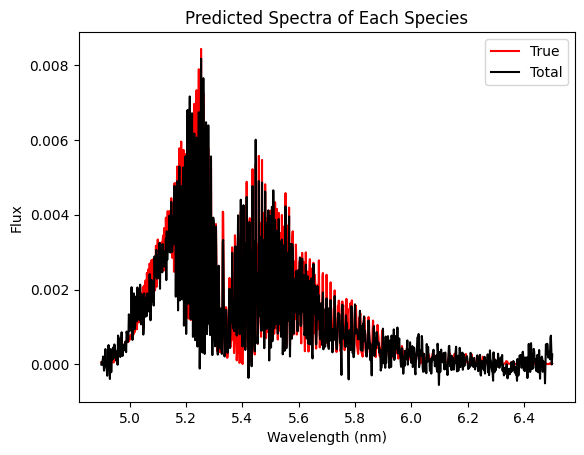

In [55]:
num = 100
x = X[num]  # shape: (10000,)
x = torch.tensor(x).unsqueeze(0).float()  # (1, 10000)
Y = torch.tensor(y[num]).squeeze(0).float()   # shape: (11, 10000)

# Sum over species to reconstruct the mixed signal
y_reconstructed = Y
with torch.no_grad():
    output = model(x)  # (1, 11, 10000)

# Plot individual species' contributions
import matplotlib.pyplot as plt
total = np.zeros(len((output[0, 0].numpy())))
for i in range(1):
    total += output[0, 0].numpy()
    # plt.plot(total_wl, output[0, i].numpy(), label=f"{species[8]}")
# plt.plot(total_wl, total, label="Total", color='black')
plt.plot(total_wl, y_reconstructed, label='True', color='red')
plt.plot(total_wl, total, label="Total", color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')
# plt.xlim(5, 5.6)
plt.legend()
plt.title("Predicted Spectra of Each Species")
plt.show()

In [56]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

In [57]:
X_new = []
y_new = []
for i, row in tqdm(df.iterrows()):
    if i in [10, 15, 16, 20, 21, 22]:
        continue
    wl = row['FLiTs Wavelength']
    NH3_wl = row['FLiTs NO Wavelength']
    NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NO Flux'])
    flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
    flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
    flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
    X_new.append(flux)
    y_new.append(NH3_flux)

X_new = np.array(X_new)
y_new = np.array(y_new)

25it [00:00, 225.06it/s]


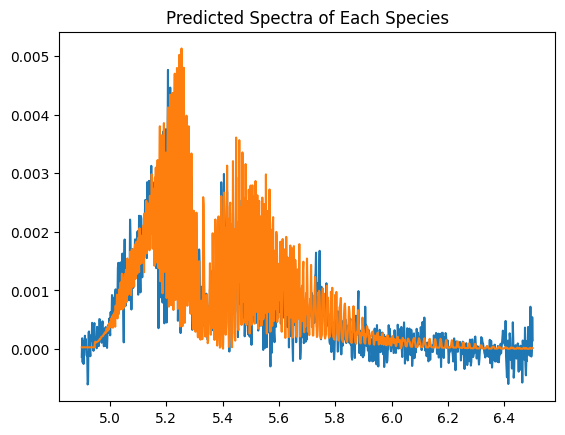

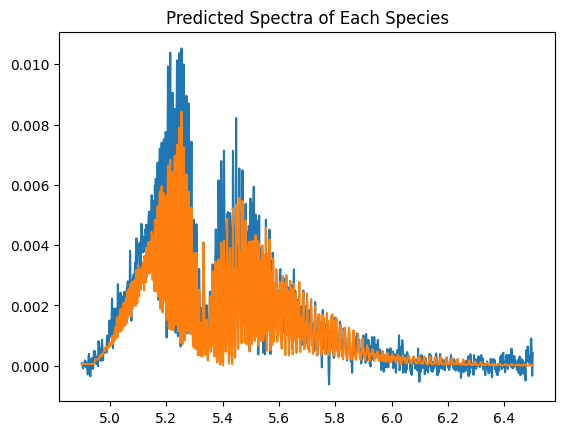

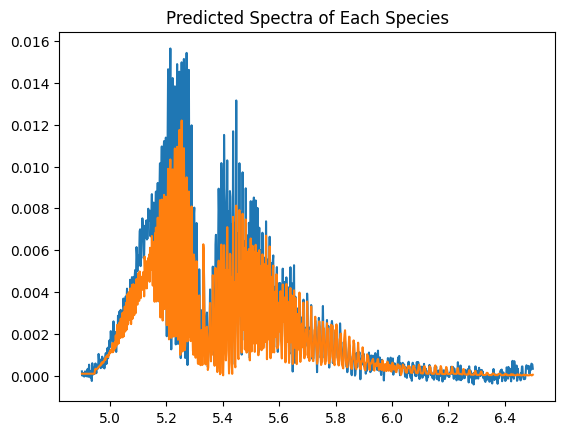

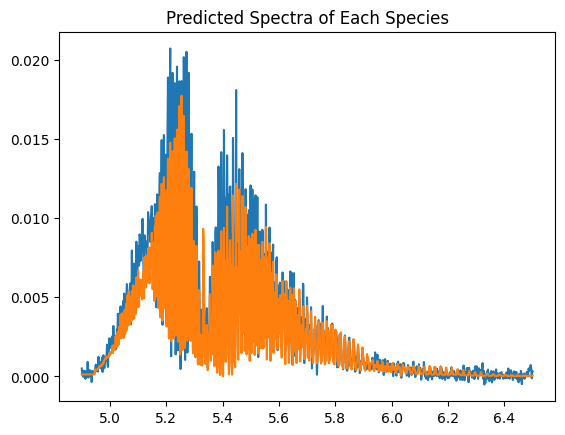

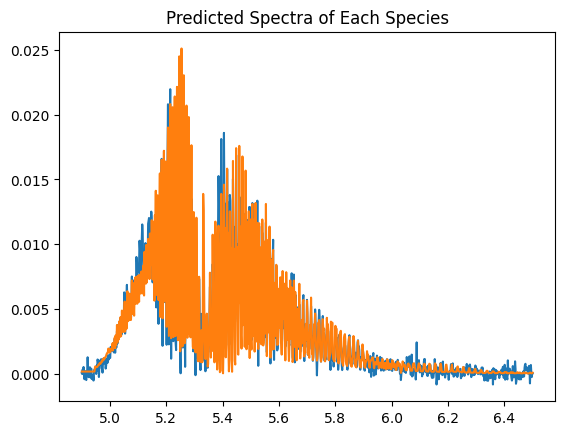

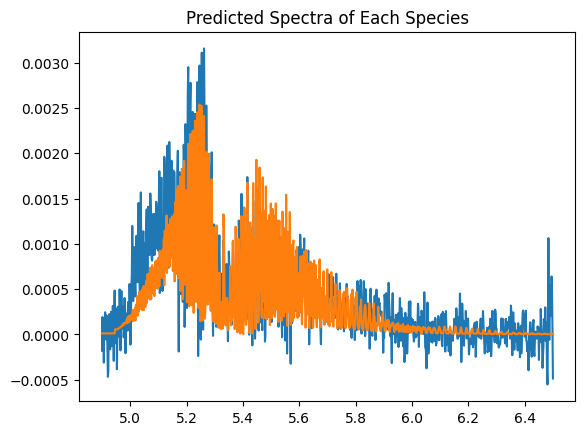

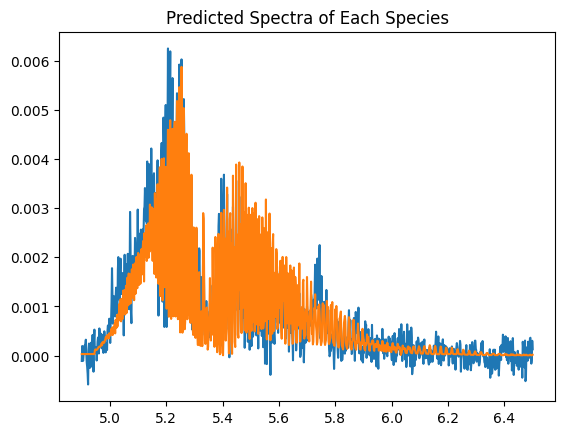

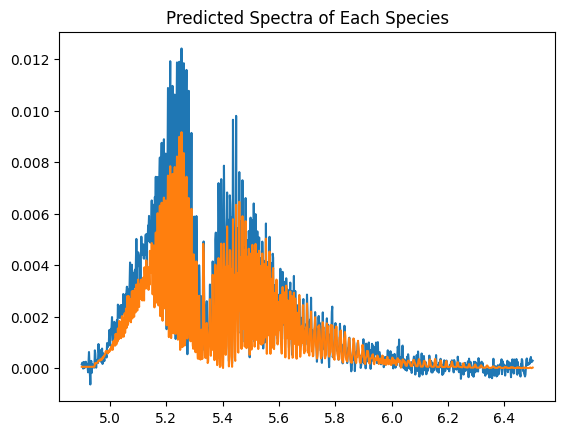

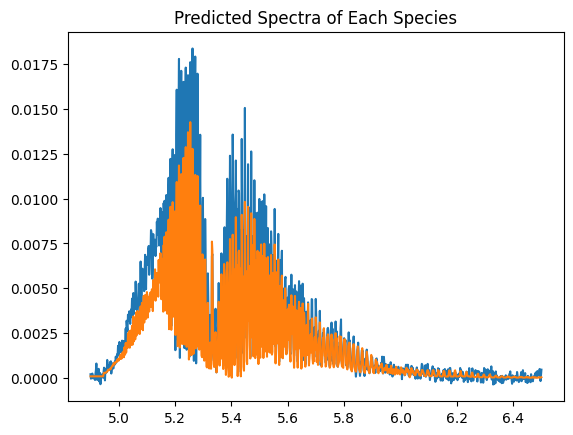

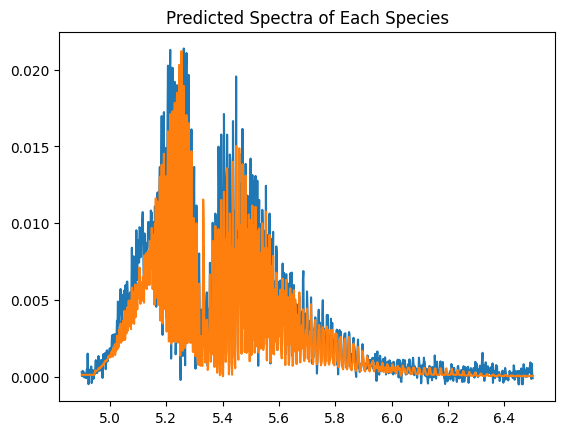

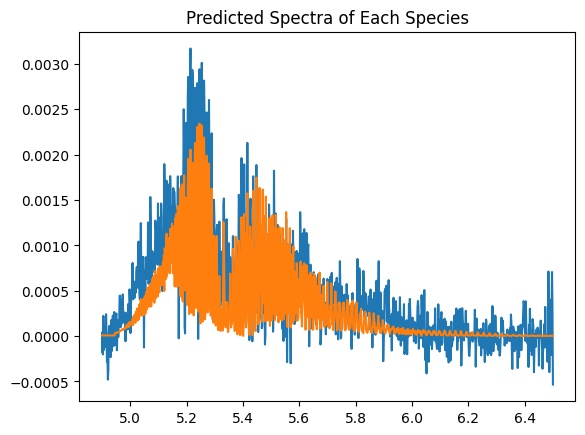

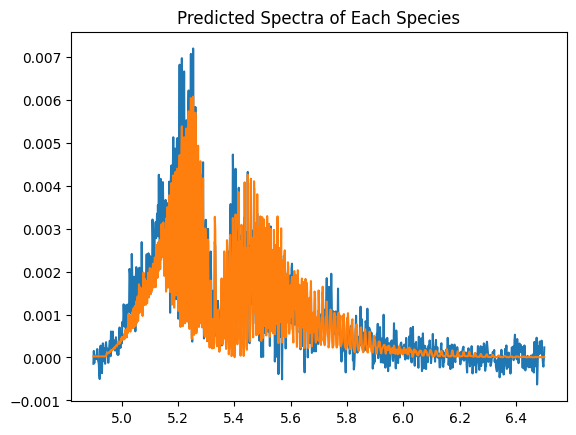

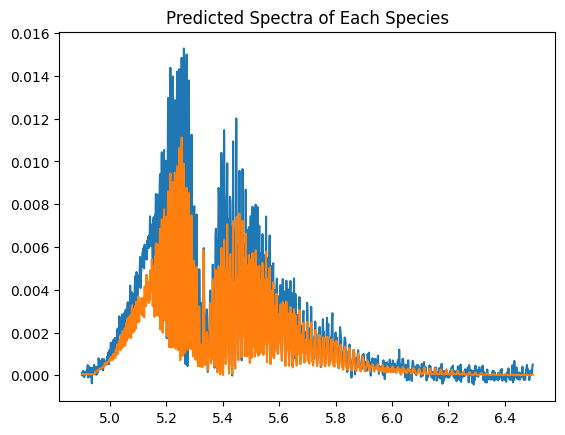

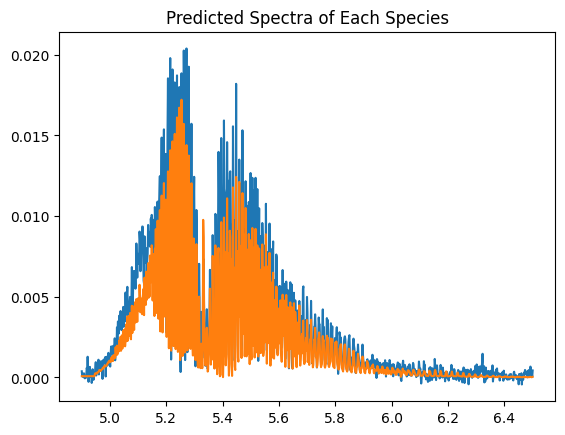

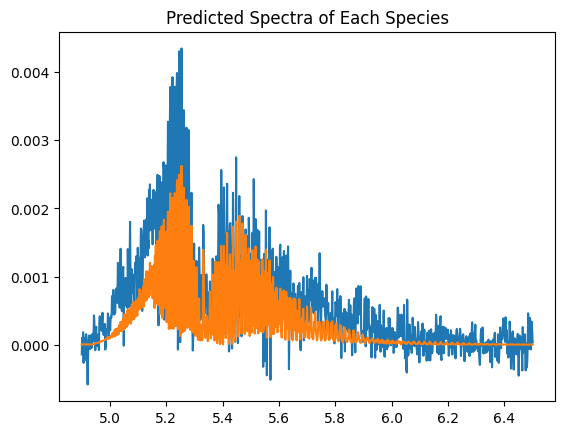

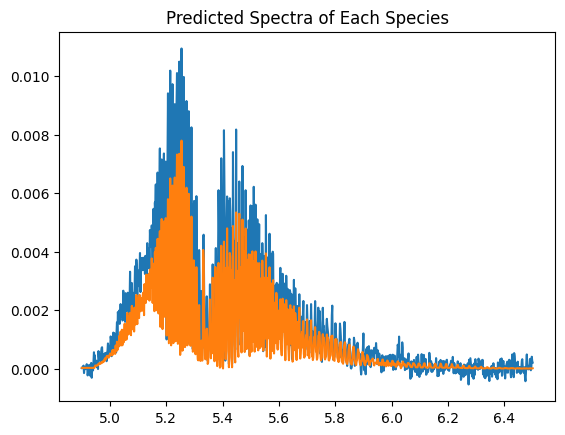

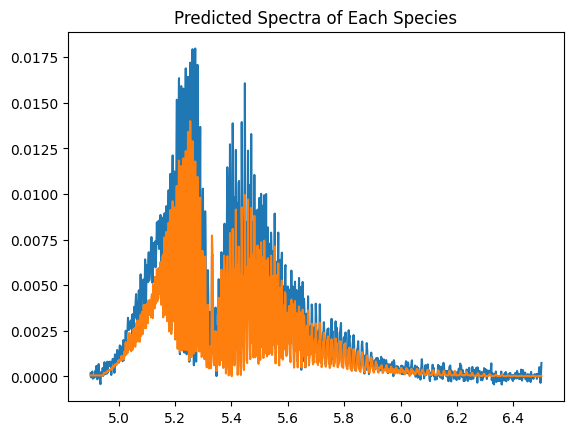

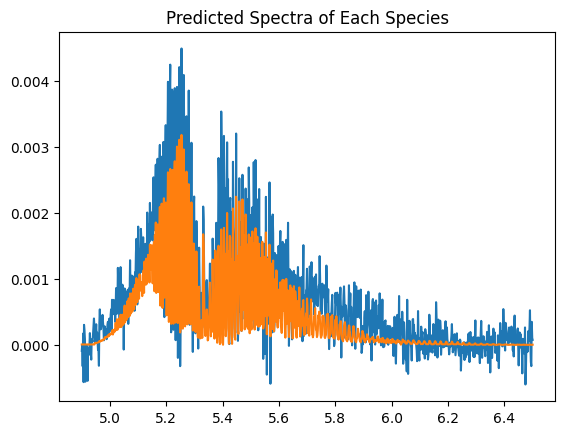

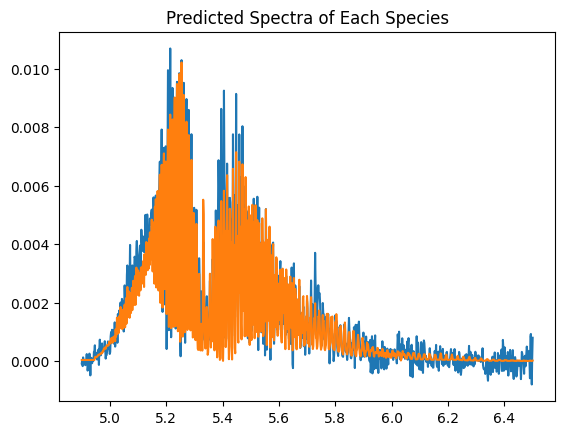

In [58]:
for i in range(19):
    x_new = X_new[i]  # shape: (10000,)
    x_new = torch.tensor(x_new).unsqueeze(0).float()
    with torch.no_grad():
        output = model(x_new)
    # total_wl = np.linspace(4.9, 7, 1000)
    plt.plot(total_wl, output[0, 0].numpy())
    # plt.legend()
    plt.plot(total_wl, y_new[i])
    plt.title("Predicted Spectra of Each Species")
    plt.show()